# Blockchain Fraud Prediction #

## 1. Import Libraries ##

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt

## 2. Load and Explore Data ##

In [21]:
# Read the dataset from a CSV file
df = pd.read_csv("Datasets/transaction_dataset.csv")

# Explore the data by looking at its dimensions
print("Dataset shape:", df.shape)

# Display the first 5 rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# View some measures of central tendency
print("\nDescriptive statistics:")
print(df.describe())

Dataset shape: (9841, 51)

First 5 rows of the dataset:
   Unnamed: 0  Index                                     Address  FLAG  \
0           0      1  0x00009277775ac7d0d59eaad8fee3d10ac6c805e8     0   
1           1      2  0x0002b44ddb1476db43c868bd494422ee4c136fed     0   
2           2      3  0x0002bda54cb772d040f779e88eb453cac0daa244     0   
3           3      4  0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e     0   
4           4      5  0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89     0   

   Avg min between sent tnx  Avg min between received tnx  \
0                    844.26                       1093.71   
1                  12709.07                       2958.44   
2                 246194.54                       2434.02   
3                  10219.60                      15785.09   
4                     36.61                      10707.77   

   Time Diff between first and last (Mins)  Sent tnx  Received Tnx  \
0                                704785.63       721          

## 3. Data Cleaning and Preprocessing ##

In [22]:
# Select only numerical columns, excluding object types
df = df.select_dtypes(exclude=['object'])

# The 'Unnamed: 0' and 'Index' columns provide no analytical value and are dropped
df = df.drop(columns=['Unnamed: 0', 'Index'])

# Drop columns with a high number of null values
df = df.drop(columns=[' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', 
                       ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', 
                       ' ERC20 avg val sent contract'])

# Check the balance of the target variable 'FLAG'
print("\nValue counts for the 'FLAG' column:")
print(df['FLAG'].value_counts())

# Drop rows with any remaining NaN values
df = df.dropna()


Value counts for the 'FLAG' column:
FLAG
0    7662
1    2179
Name: count, dtype: int64


## 4. Visualize Feature Correlation ##


Generating correlation heatmap...


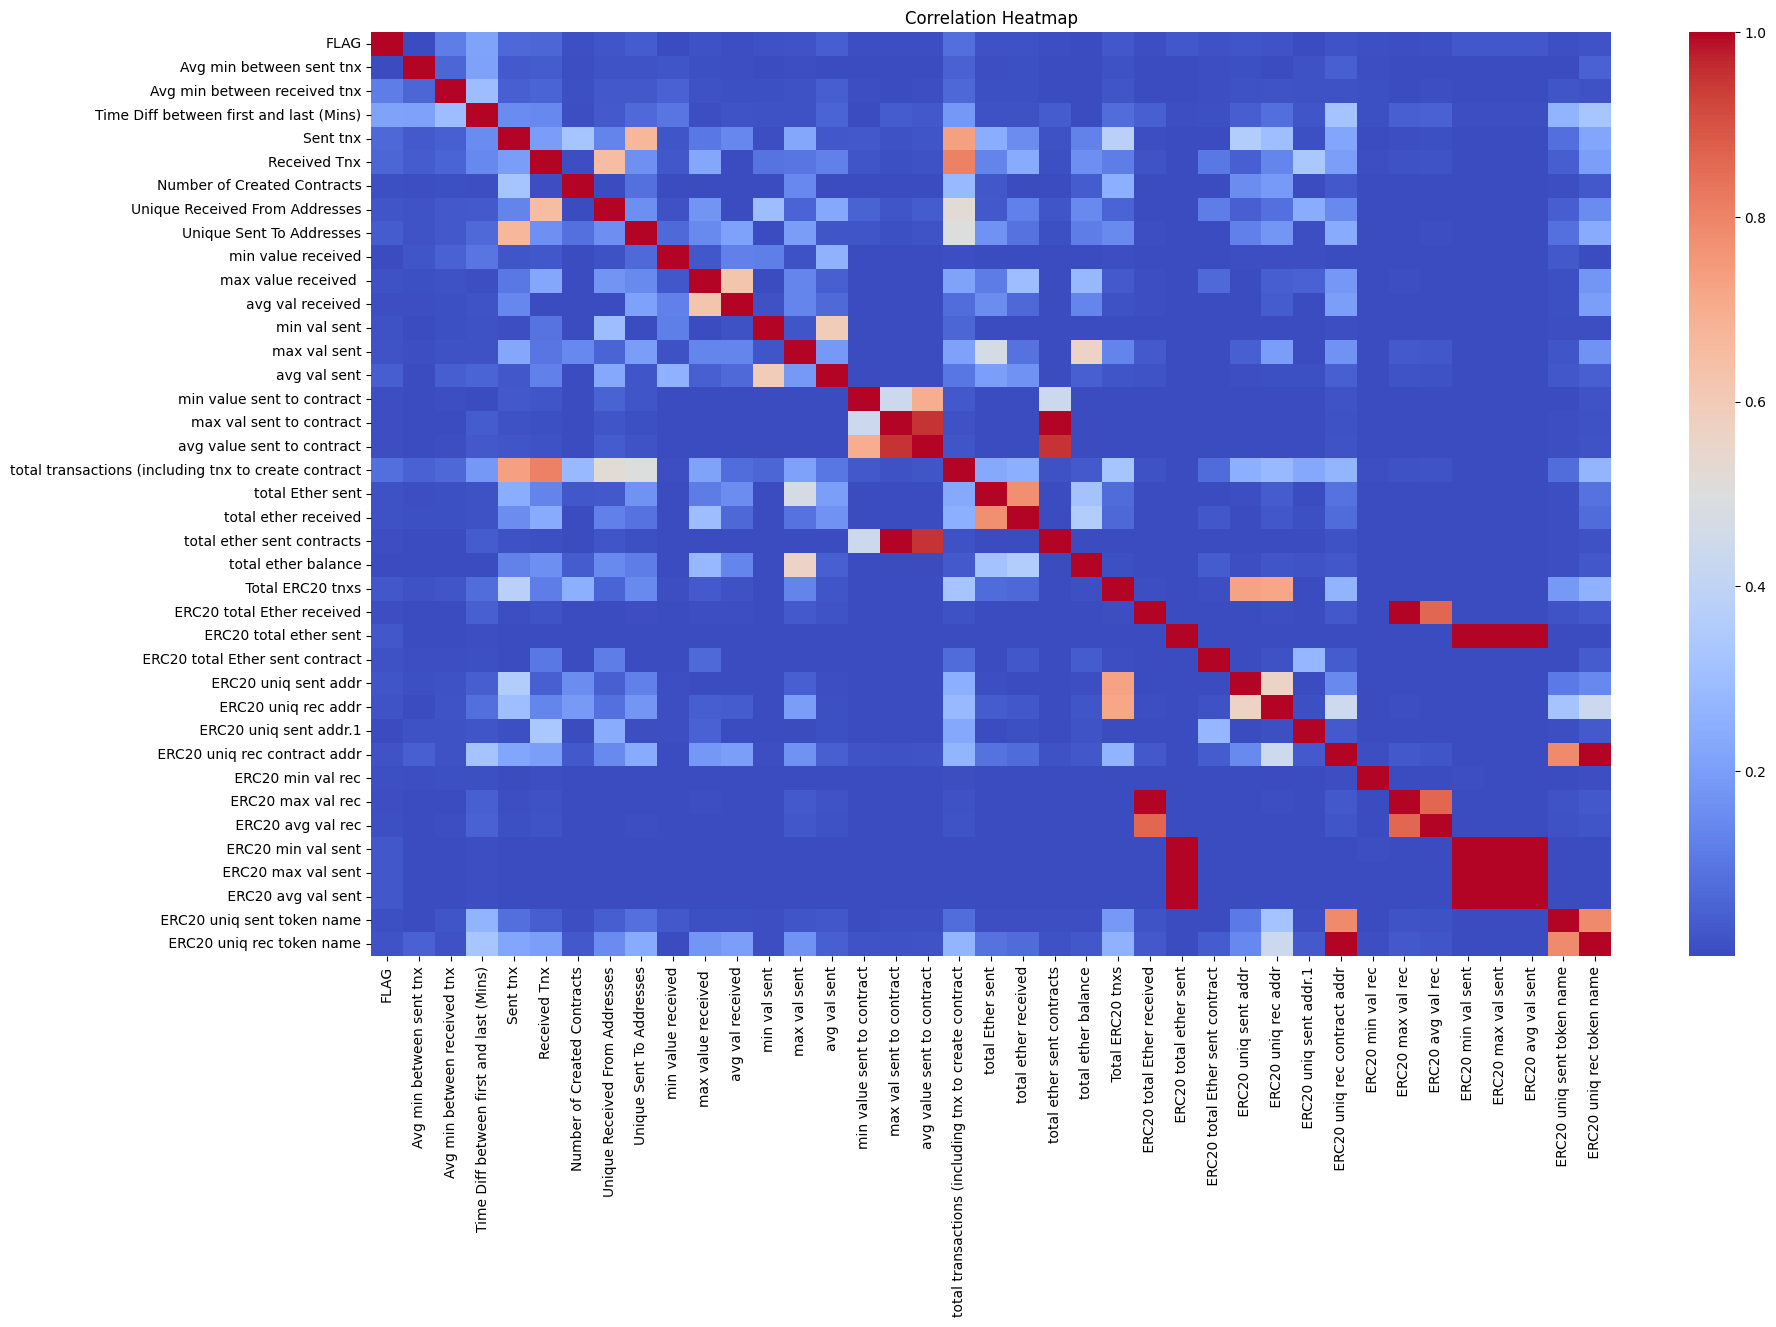

In [23]:
# Plotting the correlation between features of the dataset
print("\nGenerating correlation heatmap...")
corr = df.corr()
plt.figure(figsize=(20, 12))
sn.heatmap(np.abs(corr), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## 5. Feature Selection (Chi-Square) ##

In [24]:
# Define features (X) and target (y)
X = df.drop('FLAG', axis=1)
y = df.FLAG

# --- Chi Square Feature Selection ---
# Chi-square requires non-negative values, therefore dropping 'total ether balance'
X_chi = X.drop('total ether balance', axis=1)

# Apply SelectKBest with chi2 to find the top 35 features
# Note: A new train/test split is temporarily created here just for the fitting process
X_train_chi, X_test_chi, y_train_chi, y_test_chi = train_test_split(X_chi, y, test_size=0.3, random_state=4)

chi_best = SelectKBest(chi2, k=35).fit(X_train_chi, y_train_chi)
mask_chi = chi_best.get_support()
new_feat_chi = []
for bool_val, feature in zip(mask_chi, X_train_chi.columns):
    if bool_val:
        new_feat_chi.append(feature)

# Update X with the selected features from Chi-Square
X = X[new_feat_chi]

print("Features selected by Chi-Square:", len(new_feat_chi))

Features selected by Chi-Square: 35


## 6. Feature Selection (ANOVA F-value) ##

In [25]:
# --- ANOVA F-value Feature Selection ---
X_f = df.drop('FLAG', axis=1)
y_f = df.FLAG

# A new train/test split is temporarily created here just for the fitting process
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.3, random_state=4)

# Apply SelectKBest with f_classif to find the top 32 features
f_best = SelectKBest(f_classif, k=32).fit(X_train_f, y_train_f)
mask_f = f_best.get_support()
new_feat_f = []
for bool_val, feature in zip(mask_f, X_train_f.columns):
    if bool_val:
        new_feat_f.append(feature)

# Update X with the final selected features from ANOVA
X = X_f[new_feat_f]
y = y_f # Re-assign y for clarity

print("Features selected by ANOVA F-value:", len(new_feat_f))

Features selected by ANOVA F-value: 32


## 7. Final Data Split ##

In [26]:
# Final split of the data with the selected features for model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (6308, 32)
Testing data shape: (2704, 32)


## 8. Feature Scaling ##

In [27]:
# Cell 7a: Scale the Features

from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform both sets
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 8. Helper Functions for Tuning ##

In [31]:
# Cell 8: Helper Functions for Tuning (Corrected)

# Initialize global variables to store results
Keymax = 0
dt_rec, dt_fp = 0, 0
lr_rec, lr_fp = 0, 0
rf_rec, rf_fp = 0, 0
gbt_rec, gbt_fp = 0, 0

def perf_measure(y_actual, y_hat):
    """Calculates the number of false positives."""
    y_actual = list(y_actual)
    y_hat = list(y_hat)
    FP = 0
    for i in range(len(y_hat)): 
        if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
           FP += 1
    return FP

# CORRECTED: Changed the default parameter from 'none' (string) to None (keyword)
def tuner(model, lo=0, hi=100, l2params=['l2', None]):
    """Iterates through model parameters to find the one that yields the best recall score."""
    global Keymax, dt_rec, dt_fp, lr_rec, lr_fp, rf_rec, rf_fp, gbt_rec, gbt_fp
    paramDict = {}
    y_pred_tuned = None

    if model == 'dt':
        # Tuning for Decision Tree max_depth
        for i in range(lo, hi + 1):
            if i == 0: continue # max_depth must be > 0
            m = DecisionTreeClassifier(max_depth=i, random_state=4)
            m.fit(X_train, y_train)
            y_pred = m.predict(X_test)
            paramDict.update({i: metrics.recall_score(y_test, y_pred)})
        Keymax = max(paramDict, key=paramDict.get)
        m_best = DecisionTreeClassifier(max_depth=Keymax, random_state=4).fit(X_train, y_train)
        y_pred_tuned = m_best.predict(X_test)
        dt_rec, dt_fp = paramDict[Keymax], perf_measure(y_test, y_pred_tuned)
        return Keymax, dt_rec, dt_fp

    elif model == 'lr':
        # Tuning for Logistic Regression penalty
        for param in l2params:
            m = LogisticRegression(max_iter=1000, penalty=param, solver='lbfgs')
            m.fit(X_train, y_train)
            y_pred = m.predict(X_test)
            paramDict.update({param: metrics.recall_score(y_test, y_pred)})
        Keymax = max(paramDict, key=paramDict.get)
        m_best = LogisticRegression(max_iter=1000, penalty=Keymax, solver='lbfgs').fit(X_train, y_train)
        y_pred_tuned = m_best.predict(X_test)
        lr_rec, lr_fp = paramDict[Keymax], perf_measure(y_test, y_pred_tuned)
        return Keymax, lr_rec, lr_fp

    elif model == 'rf':
        # Tuning for Random Forest n_estimators
        for i in range(lo, hi + 1):
            if i == 0: continue # n_estimators must be > 0
            m = RandomForestClassifier(n_estimators=i, random_state=4)
            m.fit(X_train, y_train)
            y_pred = m.predict(X_test)
            paramDict.update({i: metrics.recall_score(y_test, y_pred)})
        Keymax = max(paramDict, key=paramDict.get)
        m_best = RandomForestClassifier(n_estimators=Keymax, random_state=4).fit(X_train, y_train)
        y_pred_tuned = m_best.predict(X_test)
        rf_rec, rf_fp = paramDict[Keymax], perf_measure(y_test, y_pred_tuned)
        return Keymax, rf_rec, rf_fp

    elif model == 'gbt':
        # Tuning for Gradient Boosting n_estimators
        for i in range(lo, hi + 1):
            if i == 0: continue # n_estimators must be > 0
            m = GradientBoostingClassifier(n_estimators=i, random_state=4)
            m.fit(X_train, y_train)
            y_pred = m.predict(X_test)
            paramDict.update({i: metrics.recall_score(y_test, y_pred)})
        Keymax = max(paramDict, key=paramDict.get)
        m_best = GradientBoostingClassifier(n_estimators=Keymax, random_state=4).fit(X_train, y_train)
        y_pred_tuned = m_best.predict(X_test)
        gbt_rec, gbt_fp = paramDict[Keymax], perf_measure(y_test, y_pred_tuned)
        return Keymax, gbt_rec, gbt_fp

## 9. Model 1 - Decision Tree ##

--- Decision Tree ---
Initial Recall: 0.9228915662650602
Tuning successful! Best max_depth, Recall, FP: (16, np.float64(0.9325301204819277), 47)


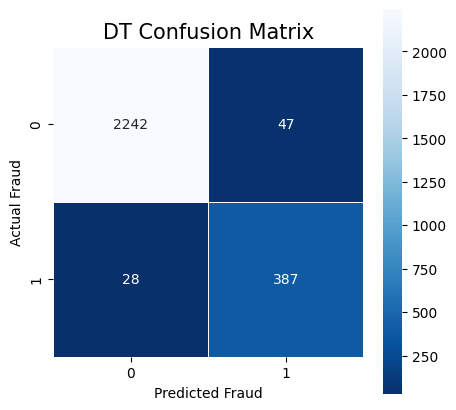

In [33]:
## --- Decision Tree Classifier ---
print("--- Decision Tree ---")
# Initial Model
dt = DecisionTreeClassifier(random_state=4)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(f"Initial Recall: {metrics.recall_score(y_test, y_pred_dt)}")

# Tuning the Decision Tree
result_dt = tuner('dt', 5, 100)
print(f"Tuning successful! Best max_depth, Recall, FP: {result_dt}")

# Visualize Confusion Matrix for tuned model
dt_tuned = DecisionTreeClassifier(max_depth=result_dt[0], random_state=4).fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)
dt_cm = metrics.confusion_matrix(y_test, y_pred_dt_tuned)
plt.figure(figsize=(5, 5))
sn.heatmap(dt_cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual Fraud')
plt.xlabel('Predicted Fraud')
plt.title('DT Confusion Matrix', size=15)
plt.show()

## 10. Model 2 - Logistic Regression ##

In [34]:
## --- Logistic Regression ---
print("\n--- Logistic Regression ---")
# Initial Model
lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"Initial Recall: {metrics.recall_score(y_test, y_pred_lr)}")

# Tune Logistic Regression
result_lr = tuner('lr')
print(f"Tuning results for LR: Best penalty, Recall, FP: {result_lr}")


--- Logistic Regression ---
Initial Recall: 0.03614457831325301
Tuning results for LR: Best penalty, Recall, FP: ('l2', np.float64(0.03614457831325301), 1)


## 11. Model 3 - Random Forest ##


--- Random Forest ---
Initial Recall: 0.9204819277108434
Tuning successful! Best n_estimators, Recall, FP: (47, np.float64(0.927710843373494), 8)


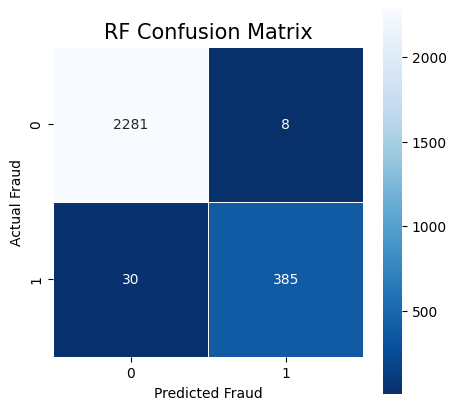

In [37]:
## --- Random Forest Classifier ---
print("\n--- Random Forest ---")
# Initial Model
rf = RandomForestClassifier(random_state=4)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Initial Recall: {metrics.recall_score(y_test, y_pred_rf)}")

# Tune Random Forest
result_rf = tuner('rf', 5, 100)
print(f"Tuning successful! Best n_estimators, Recall, FP: {result_rf}")

# Visualize Confusion Matrix for tuned model
rf_tuned = RandomForestClassifier(n_estimators=result_rf[0], random_state=4).fit(X_train, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test)
rf_cm = metrics.confusion_matrix(y_test, y_pred_rf_tuned)
plt.figure(figsize=(5,5))
sn.heatmap(rf_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual Fraud')
plt.xlabel('Predicted Fraud')
plt.title('RF Confusion Matrix', size = 15)
plt.show()

## 12. Model 4 - Gradient Boosting ##


--- Gradient Boosting ---
Initial Recall: 0.9132530120481928
Tuning results for GBT: Best n_estimators, Recall, FP: (44, np.float64(0.8795180722891566), 13)


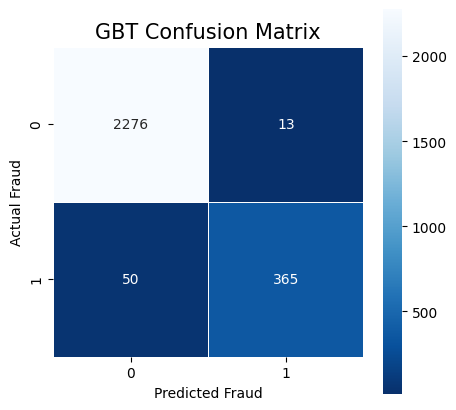

In [38]:
## --- Gradient Boosting Classifier ---
print("\n--- Gradient Boosting ---")
# Initial Model
gbt = GradientBoostingClassifier(random_state=4)
gbt.fit(X_train, y_train)
y_pred_gbt = gbt.predict(X_test)
print(f"Initial Recall: {metrics.recall_score(y_test, y_pred_gbt)}")

# Tuning the Gradient Boost
result_gbt = tuner('gbt', 5, 50)
print(f"Tuning results for GBT: Best n_estimators, Recall, FP: {result_gbt}")

# Visualize Confusion Matrix for tuned model
gbt_tuned = GradientBoostingClassifier(n_estimators=result_gbt[0], random_state=4).fit(X_train, y_train)
y_pred_gbt_tuned = gbt_tuned.predict(X_test)
gbt_cm = metrics.confusion_matrix(y_test, y_pred_gbt_tuned)
plt.figure(figsize=(5,5))
sn.heatmap(gbt_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual Fraud')
plt.xlabel('Predicted Fraud')
plt.title('GBT Confusion Matrix', size = 15)
plt.show()

## 13. Final Model Comparison ##

In [40]:
# --- Final Model Comparison ---
print("\n--- Final Model Comparison ---")
data = [
    ["Decision Tree", dt_rec, dt_fp],
    ["Logistic Regression", lr_rec, lr_fp],
    ["Random Forest", rf_rec, rf_fp],
    ["Gradient Boost", gbt_rec, gbt_fp]
]

resultsdf = pd.DataFrame(data, columns=["Model", "Recall Score", "False Positives"])

resultsdf


--- Final Model Comparison ---


,Model,Recall Score,False Positives
0,Decision Tree,0.932530,47
1,Logistic Regression,0.036145,1
2,Random Forest,0.927711,8
3,Gradient Boost,0.879518,13
